# Problem 1.3: Voltage Peaks - data reader

The following is a small program to read the data file "data_VoltagePeaks.txt", which contains a single column: Voltage.

### Author & Date: 
- Troels C. Petersen (Niels Bohr Institute)
- 07-11-2021

***

In [275]:
import numpy as np                                     # Matlab like syntax for linear algebra and functions
import matplotlib.pyplot as plt                        # Plots and figures like you know them from Matlab
import seaborn as sns                                  # Make the plots nicer to look at
from iminuit import Minuit                             # The actual fitting tool, better than scipy's
import sys                                             # Module to see files and folders in directories
from scipy import stats

In [276]:
sys.path.append('D:\my github\Siyi Applied Stats\Documents for JN\AppStat2021-main\External_Functions\\')
from ExternalFunctions import UnbinnedLH, BinnedLH, Chi2Regression
from ExternalFunctions import nice_string_output, add_text_to_ax # useful functions to print fit results on figure

In [277]:
# Read the data and print it to check it:
voltage = np.loadtxt("data_VoltagePeaks.txt")

print("Number of entries: ", len(voltage))
for i in range(10) : 
    print(f"  {voltage[i]:14.6f}")

Number of entries:  1000000
        1.119280
        1.828920
        0.797830
        2.715827
        1.496780
       12.176045
       24.154821
        1.981145
        0.677696
        0.604801


In [278]:
save_plots = False # For now, don't save plots (once you trust your code, switch on)
verbose = True     # For now, print a lot of output (once you trust your code, switch off)
Nverbose = 10      # But only print a lot for the first 10 random numbers

In [279]:
N_voltage = 84721  # 本图xmin, xmax = 2.5, 3.5范围内voltage点的个数
Npeak = 7367     # Number of random Gaussian points
Nbkg  = 77354   # Number of random Exponential points

xmin, xmax = 2.9,3.0  # 图表显示的范围
Nbins = 100
binwidth = (xmax-xmin)/Nbins  #binwidth = (xmax-xmin)/Nbins
print(binwidth)

condition = (voltage<xmax)*(voltage>xmin)
x_all = voltage[condition]  # x_2是本图xmin, xmax = 2.5, 3.5范围内voltage点,x是将x_2 binned后的
print(np.size(x_all))
print(type(x_all))

# Find the x, y and error on y (sy) given the histogram:
counts, bin_edges = np.histogram(x_all, bins=Nbins, range=(xmin, xmax))
x = (bin_edges[1:][counts>0] + bin_edges[:-1][counts>0])/2
y = counts[counts>0]
sy = np.sqrt(counts[counts>0])   # NOTE: We (naturally) assume that the bin count is Poisson distributed.
                       # This is an approximation, since there is a low count in the last bins.

# print(np.where(y==177))
print(x)
print(y)


0.0010000000000000009
9687
<class 'numpy.ndarray'>
[2.9005 2.9015 2.9025 2.9035 2.9045 2.9055 2.9065 2.9075 2.9085 2.9095
 2.9105 2.9115 2.9125 2.9135 2.9145 2.9155 2.9165 2.9175 2.9185 2.9195
 2.9205 2.9215 2.9225 2.9235 2.9245 2.9255 2.9265 2.9275 2.9285 2.9295
 2.9305 2.9315 2.9325 2.9335 2.9345 2.9355 2.9365 2.9375 2.9385 2.9395
 2.9405 2.9415 2.9425 2.9435 2.9445 2.9455 2.9465 2.9475 2.9485 2.9495
 2.9505 2.9515 2.9525 2.9535 2.9545 2.9555 2.9565 2.9575 2.9585 2.9595
 2.9605 2.9615 2.9625 2.9635 2.9645 2.9655 2.9665 2.9675 2.9685 2.9695
 2.9705 2.9715 2.9725 2.9735 2.9745 2.9755 2.9765 2.9775 2.9785 2.9795
 2.9805 2.9815 2.9825 2.9835 2.9845 2.9855 2.9865 2.9875 2.9885 2.9895
 2.9905 2.9915 2.9925 2.9935 2.9945 2.9955 2.9965 2.9975 2.9985 2.9995]
[ 83  78  82  79  90 101  84  84  96  82  82 107  96  86  77  85  84  76
 104  80 106  84  86  85  81  79  83 110  87  84  93  87  99  88  91  88
  85  90 108 116  96  99 107 125 139 130 154 146 177 155 158 164 162 172
 145 158 122 137 13

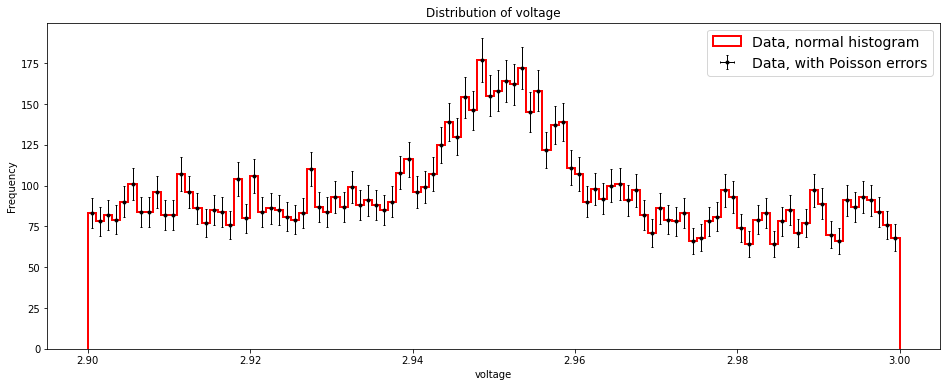

In [280]:
# Create just a single figure and axes, and a (classic) histogram:
fig, ax = plt.subplots(figsize=(16, 6))  # figsize is in inches
hist = ax.hist(x_all, bins=Nbins, range=(xmin, xmax), histtype='step', linewidth=2,color='red', label='Data, normal histogram')

ax.errorbar(x, y, yerr=sy, xerr=0.0, label='Data, with Poisson errors', fmt='.k',  ecolor='k', elinewidth=1, capsize=1, capthick=1)

# Set the figure texts; xlabel, ylabel and title.
ax.set(xlabel="voltage",           # the label of the y axis
       ylabel="Frequency",           # the label of the y axis
       title="Distribution of voltage")    # the title of the plot
ax.legend(loc='best', fontsize=14);       # could also be # loc = 'upper right' e.g.


fig.savefig('fig1',dpi=600)

In [281]:
# Define your actual fitting function, with both background and signal in:
# which is NOT normalised but has normalisation constants "N" in, and includes the bin width:
def fit_pdf(x, Nexp, tau, Ngauss, mu, sigma) :
    """Exponential + Gaussian"""
    return Nexp * binwidth * (1.0 / tau * np.exp(-x/tau))+ Ngauss * binwidth * (1.0 / np.sqrt(2*np.pi) / sigma * np.exp( -0.5 * (x-mu)**2 / sigma**2))  # 比下面的函数多乘了binwidth

In [282]:
Minuit.print_level = 1    # Print result of fits (generally - can also be moved down to each fit instance)

# Defining Chi2 calculation:
def chi2_owncalc(Nexp, tau, Ngauss, mu, sigma) :
    y_fit = fit_pdf(x, Nexp, tau, Ngauss, mu, sigma)
    chi2 = np.sum(((y - y_fit) / sy)**2)
    return chi2

# Alternatively, use the Chi2 regression from External Functions:
chi2fit = Chi2Regression(fit_pdf, x, y, sy)

minuit_chi2 = Minuit(chi2_owncalc, Nexp=Nbkg, tau=2.7, Ngauss=Npeak, mu=3.1, sigma=0.3) 
minuit_chi2.errordef = 1.0     # This is the definition for ChiSqaure fits
minuit_chi2.migrad()           # This is where the minimisation is carried out! Put ";" at the end to void output

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 94.43                      │             Nfcn = 1076              │
│ EDM = 0.0128 (Goal: 0.0002)      │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│         INVALID Minimum          │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           ABOVE call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │APPROXIMATE│  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name   │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ Nexp   │  1.54e6   │  0.32e6   │            │            │         │         │       │
│ 1 │ tau    │   1.02    │   0.12    │            │            │         │         │       │
│ 2 │ Ngauss │  1.30e3   │  0.08e3   │            │            │         │         │       │
│ 3 │ mu     │  2.9511   │  0.0004   │            │            │         │         │       │
│ 4 │ sigma  │  6.4e-3   │  0.4e-3   │            │            │         │         │       │
└───┴────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────────┬───────────────────────────────────────────────────┐
│        │      Nexp       tau    Ngauss        mu     sigma │
├────────┼───────────────────────────────────────────────────┤
│   Nexp │  1.04e+11 -3.86e+04  3.94e+06     -10.7      4.48 │
│    tau │ -3.86e+04    0.0143     -1.67  3.65e-06 -2.69e-06 │
│ Ngauss │  3.94e+06     -1.67  6.02e+03 -0.000549    0.0174 │
│     mu │     -10.7  3.65e-06 -0.000549  1.37e-07 -4.36e-09 │
│  sigma │      4.48 -2.69e-06    0.0174 -4.36e-09  1.61e-07 │
└────────┴───────────────────────────────────────────────────┘

In [283]:
# First, check if the result was a valid minimum:
if (not minuit_chi2.fmin.is_valid) :
    print("  WARNING: The ChiSquare fit DID NOT converge!!! ")    
    
# Short hand way of accessing the fit parameters:
fit_Ngauss, fit_mu, fit_sigma, fit_Nexp, fit_tau = minuit_chi2.values[:]   # The fitted values of the parameters

# Loop to get both parameter values and uncertainties:
for name in minuit_chi2.parameters :
    value, error = minuit_chi2.values[name], minuit_chi2.errors[name]
    print(f"Fit value: {name} = {value:.5f} +/- {error:.5f}")

# Get Chi2 value:
chi2_value = minuit_chi2.fval            # The value minimised, i.e. Chi2 or -2*LogLikeliHood (LLH) value

# Get number of degrees-of-freedom (Ndof):
N_NotEmptyBin = np.sum(y > 0)
Ndof_value = N_NotEmptyBin - minuit_chi2.nfit

Prob_value = stats.chi2.sf(chi2_value, Ndof_value) # The chi2 probability given N_DOF degrees of freedom
print(f"Chi2 value: {chi2_value:.1f}   Ndof = {Ndof_value:.0f}    Prob(Chi2,Ndof) = {Prob_value:5.3f}")

Fit value: Nexp = 1536088.21951 +/- 323105.61435
Fit value: tau = 1.01552 +/- 0.11948
Fit value: Ngauss = 1297.40836 +/- 77.58249
Fit value: mu = 2.95111 +/- 0.00037
Fit value: sigma = 0.00637 +/- 0.00040
Chi2 value: 94.4   Ndof = 95    Prob(Chi2,Ndof) = 0.497


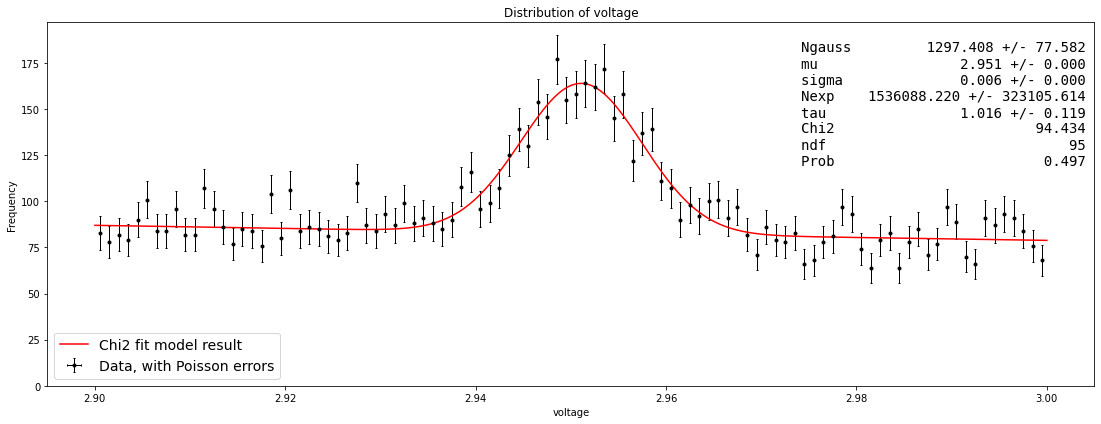

In [284]:

# Create just a single figure and axes, along with a histogram with uncertainties:
fig, ax = plt.subplots(figsize=(16, 6))  # figsize is in inches
ax.errorbar(x, y, yerr=sy, xerr=0.0, label='Data, with Poisson errors', fmt='.k',  ecolor='k', elinewidth=1, capsize=1, capthick=1)

# Set the figure texts; xlabel, ylabel and title.
ax.set(xlabel="voltage", # the label of the y axis
       ylabel="Frequency",  # the label of the y axis
       title="Distribution of voltage", # the title of the plot
       ylim=[0.0,None]) # Setting the miminum to zero

# Adding fit function to plot:
x_axis = np.linspace(xmin,xmax, 1000)
ax.plot(x_axis, fit_pdf(x_axis, *minuit_chi2.values[:]), '-r', label='Chi2 fit model result') 

# Adding fit results to plot:
d = {'Ngauss':   [minuit_chi2.values['Ngauss'], minuit_chi2.errors['Ngauss']],
     'mu':       [minuit_chi2.values['mu'], minuit_chi2.errors['mu']],
     'sigma':    [minuit_chi2.values['sigma'], minuit_chi2.errors['sigma']],
     'Nexp':     [minuit_chi2.values['Nexp'], minuit_chi2.errors['Nexp']],
     'tau':         [minuit_chi2.values['tau'], minuit_chi2.errors['tau']],
     'Chi2':     chi2_value,
     'ndf':      Ndof_value,
     'Prob':     Prob_value,
    }


#"%e" %
text = nice_string_output(d, extra_spacing=2, decimals=3)
add_text_to_ax(0.72, 0.95, text, ax, fontsize=14)
ax.legend(loc='lower left', fontsize=14); # could also be # loc = 'upper right' e.g.
fig.tight_layout()
fig.savefig('fig2',dpi=600)